In [33]:
%matplotlib inline

import time
import numpy as np
from numpy import inf
import matplotlib.pyplot as plt

import lqg1d
import utils
from tqdm import tqdm

In [34]:
class ConstantStep(object):
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def update(self, gt):
        return self.learning_rate * gt

In [35]:
class AnnealingStep(object):
    def __init__(self, learning_rate, decay_rate):
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
    
    def update(self, gt):
        return self.learning_rate * self.decay_rate * gt

In [36]:
class AdamStep(object):
    def __init__(self, beta1, beta2, eps, learning_rate):
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.learning_rate = learning_rate
        self.m = 0
        self.v = 0
        self.t = 1
        
    def update(self, gt):
        self.m = self.beta1 * self.m + (1 - self.beta1) * gt
        self.v = self.beta2 * self.v + (1 - self.beta2) * (gt * gt)
        
        mean_m = self.m / (1 - self.beta1** self.t)
        mean_v = self.v / (1 - self.beta2** self.t)
        
        self.t += 1
        
        delta_g = self.learning_rate / (np.sqrt(mean_v) + self.eps) * mean_m
        return delta_g

## Define environment and policy

In [37]:
env = lqg1d.LQG1D(initial_state_type='random')

In [38]:
# we consider a fixed standard deviation sigma_w(s) = 0.5
# \mu_{\theta}(s) = \theta s
class Policy(object):
    def __init__(self, theta=None, sigma=0.5):
        self.theta = np.random.rand(1) if theta is None else theta
        self.sigma = sigma
        
    def draw_action(self, state):
        #np.random.seed(42)
        return np.random.normal(self.theta * state, self.sigma)
    
    def update(self, action, state):
        return float((action - self.theta * state)/(self.sigma**2) * state)

In [39]:
N = 100 # We will collect N trajectories per iteration (nb episodes)
T = 100 # Each trajectory will have at most T time steps
n_itr = 50 # Number of policy parameters updates
discount = 0.9 # Set the discount factor for the problem
learning_rate = 0.1 # Learning rate for the gradient update

In [40]:
def reinforce(n_itr, N, T, discount, stepper):
    mean_parameters = []
    avg_return = []
    theta = 0 # np.random.rand(1)

    gammas = np.array([discount**t for t in range(T)])

    for _ in tqdm(range(n_itr)):
        policy = Policy(theta)
        paths = utils.collect_episodes(env, policy=policy, horizon=T, n_episodes=N)
        
        grad = 0
        avg_reward = 0

        for i in range(N):
            R = np.sum(gammas * paths[i]['rewards'])

            actions = paths[i]['actions']
            states = paths[i]['states']

            grad += np.sum([policy.update(a, s) for (a, s) in zip(actions, states)]) * R

            avg_reward += R

        avg_reward /= N    
        grad /= N

        theta = theta + stepper.update(grad)

        # append parameters to list
        avg_return.append(avg_reward)    
        mean_parameters.append(theta)
        
    return avg_return, mean_parameters

In [113]:
adam = AdamStep(0.9, 0.999, 1e-8, learning_rate)
avg_return, mean_parameters = reinforce(n_itr, N, T, discount, adam)

100%|██████████| 50/50 [00:19<00:00,  2.60it/s]


### Plot using adam

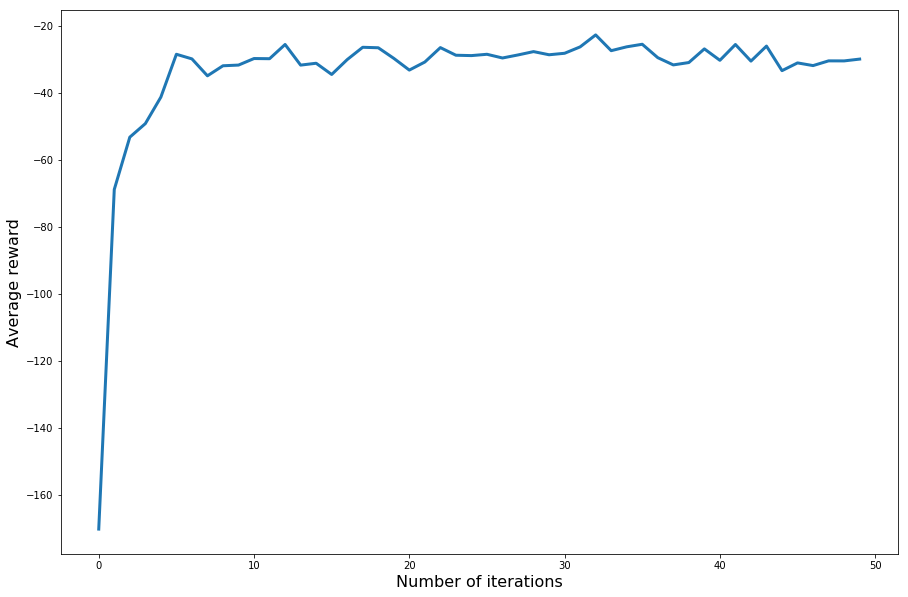

In [100]:
plt.figure(figsize=(15,10))
plt.plot(avg_return, linewidth=3)
plt.xlabel('Number of iterations', size=16)
plt.ylabel('Average reward', size=16)

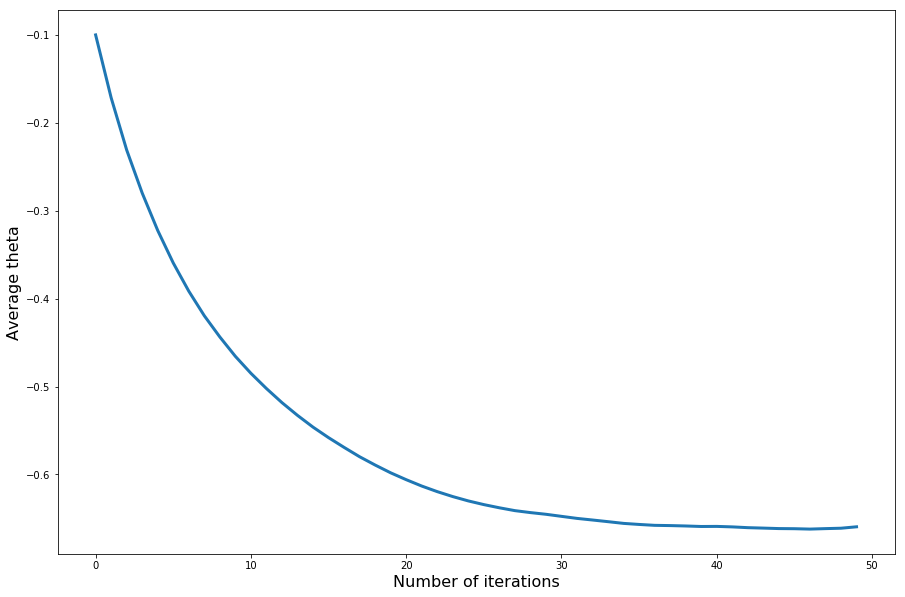

In [102]:
plt.figure(figsize=(15,10))
plt.plot(mean_parameters, linewidth=3)
plt.xlabel('Number of iterations', size=16)
plt.ylabel('Average theta', size=16)

### 1. Parameters tuning

#### 1.1 Constant stepper

In [114]:
# parameters
N = 100 # We will collect N trajectories per iteration (nb episodes)
T = 100 # Each trajectory will have at most T time steps
n_itr = 100 # Number of policy parameters updates
discount = 0.9 # Set the discount factor for the problem
learning_rate = 0.1 # Learning rate for the gradient update
n_runs = 5 # number of runs (set to 5 according to the pdf)

learning_rates = np.logspace(-8, -1, 12)

nb_curves = learning_rates.shape[0]

rewards = np.zeros((nb_curves, n_itr))
theta = np.zeros((nb_curves, n_itr))

for i, lr in enumerate(learning_rates):
    for j in range(n_runs):
        stepper = ConstantStep(lr)
        avg_return, mean_parameters = reinforce(n_itr, N, T, discount, stepper)
        
        rewards[i] += np.array(avg_return)
        theta[i] += np.array(mean_parameters)
        
rewards /= n_runs
theta /= n_runs

100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


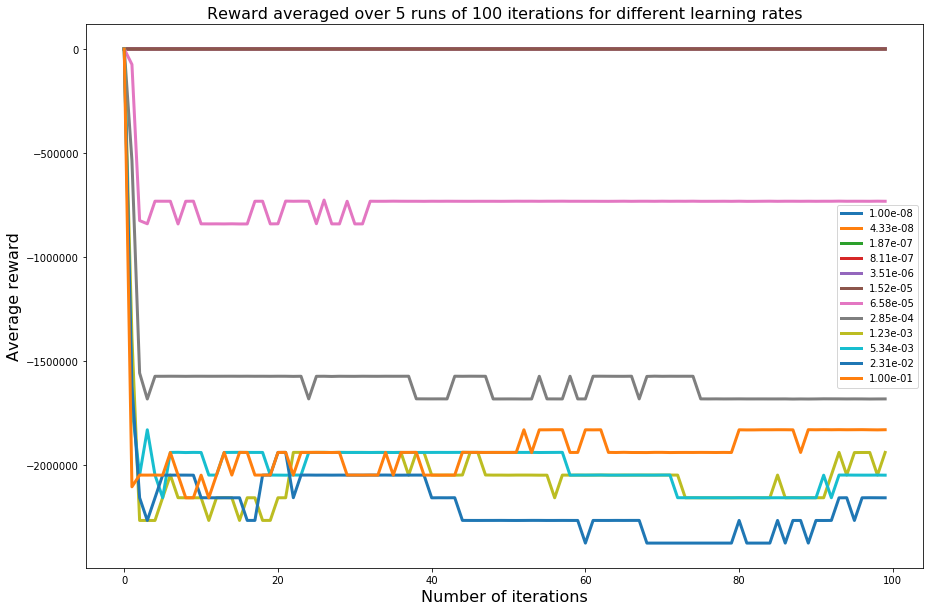

In [146]:
plt.figure(figsize=(15,10))
for i, lr in enumerate(learning_rates):
    plt.plot(rewards[i], linewidth=3, label="%0.2e" % lr)
plt.xlabel('Number of iterations', size=16)
plt.ylabel('Average reward', size=16)
plt.title('Reward averaged over %d runs of %d iterations for different learning rates' % (n_runs, n_itr), size=16)
plt.legend()

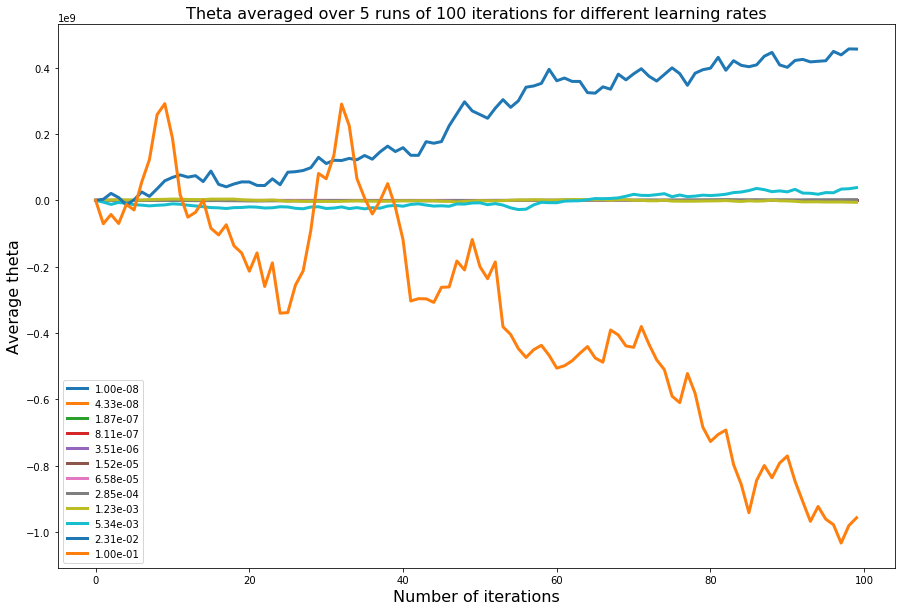

In [147]:
plt.figure(figsize=(15,10))
for i, lr in enumerate(learning_rates):
    plt.plot(theta[i], linewidth=3, label="%0.2e" % lr)
plt.xlabel('Number of iterations', size=16)
plt.ylabel('Average theta', size=16)
plt.title('Theta averaged over %d runs of %d iterations for different learning rates' % (n_runs, n_itr), size=16)
plt.legend()

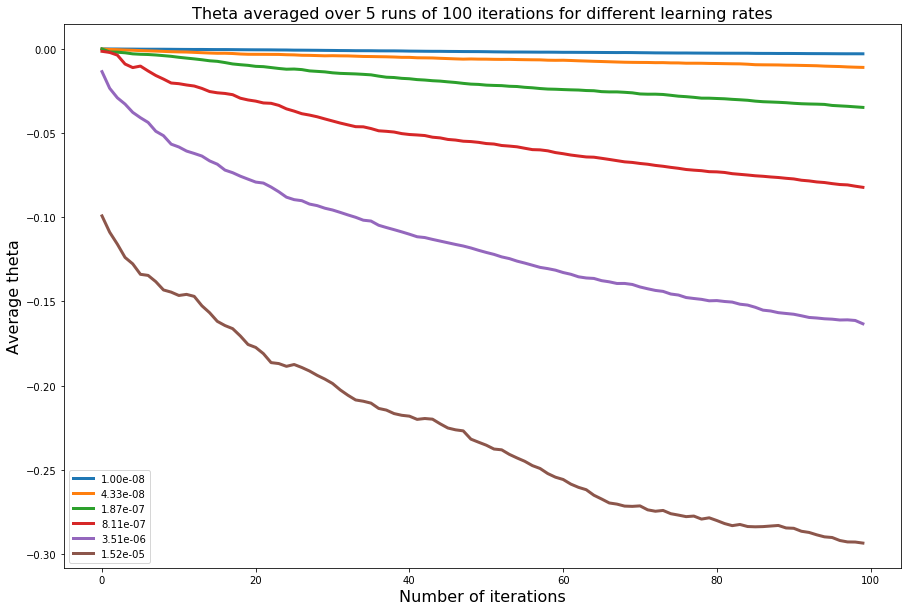

In [148]:
plt.figure(figsize=(15,10))
for i, lr in enumerate(learning_rates):
    if not (np.any(theta[i] > 2) or np.any(theta[i] < -2)): # triming inconsistent learning rate
        plt.plot(theta[i], linewidth=3, label="%0.2e" % lr)
plt.xlabel('Number of iterations', size=16)
plt.ylabel('Average theta', size=16)
plt.title('Theta averaged over %d runs of %d iterations for different learning rates' % (n_runs, n_itr), size=16)
plt.legend()

We can see that the best learning rate for the constant stepper is $\alpha$ = 1.52e-05

#### 1.2 Annealing stepper

using the best learning rate ($\alpha$ = 1.52e-05) from the constant stepper, and tuning the decay learning rate we got:

In [164]:
# parameters
N = 100 # We will collect N trajectories per iteration (nb episodes)
T = 100 # Each trajectory will have at most T time steps
n_itr = 100 # Number of policy parameters updates
discount = 0.9 # Set the discount factor for the problem
learning_rate = 0.1 # Learning rate for the gradient update
n_runs = 5 # number of runs (set to 5 according to the pdf)
lr = 1.52e-5 # best learning rate from constant stepper

learning_decay = np.linspace(0.95, 1, 12)

nb_curves = learning_decay.shape[0]

rewards = np.zeros((nb_curves, n_itr))
theta = np.zeros((nb_curves, n_itr))

for i, ld in enumerate(learning_decay):
    for j in range(n_runs):
        stepper = AnnealingStep(lr, ld)
        avg_return, mean_parameters = reinforce(n_itr, N, T, discount, stepper)
        
        rewards[i] += np.array(avg_return)
        theta[i] += np.array(mean_parameters)
        
rewards /= n_runs
theta /= n_runs

100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


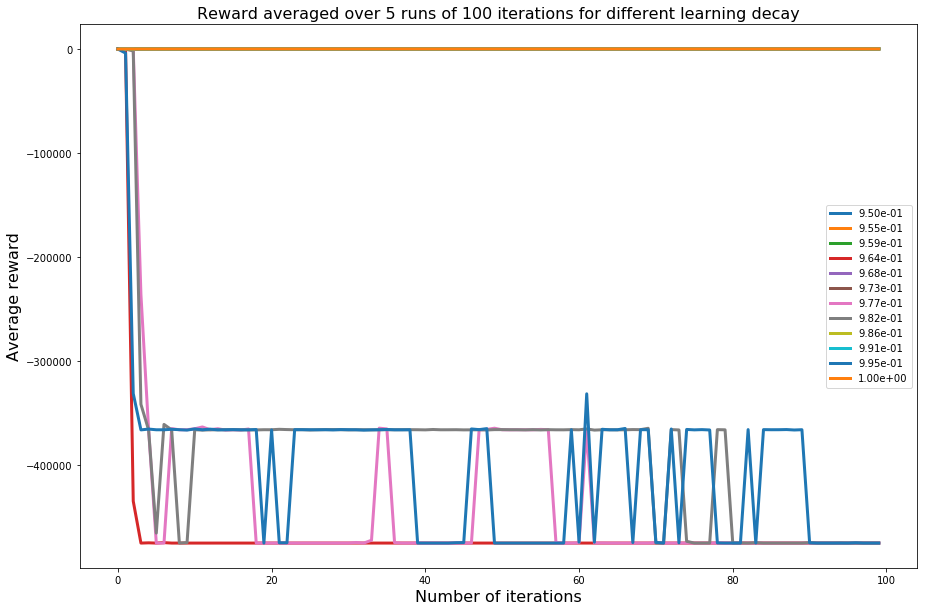

In [165]:
plt.figure(figsize=(15,10))
for i, ld in enumerate(learning_decay):
    plt.plot(rewards[i], linewidth=3, label="%0.2e" % ld)
plt.xlabel('Number of iterations', size=16)
plt.ylabel('Average reward', size=16)
plt.title('Reward averaged over %d runs of %d iterations for different learning decay' % (n_runs, n_itr), size=16)
plt.legend()

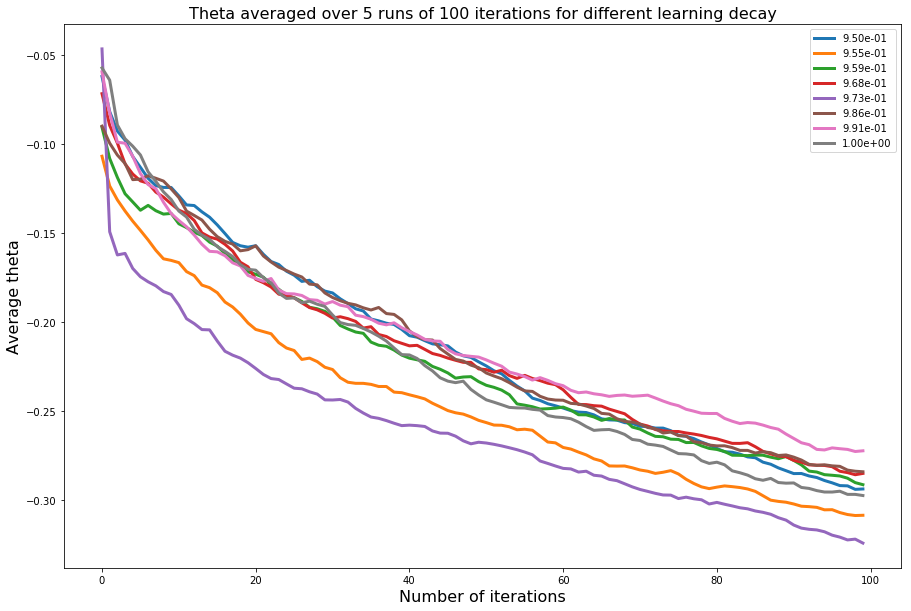

In [168]:
plt.figure(figsize=(15,10))
for i, ld in enumerate(learning_decay):
    if not (np.any(theta[i] > 2) or np.any(theta[i] < -2)): # triming inconsistent learning decay
        plt.plot(theta[i], linewidth=3, label="%0.2e" % ld)
plt.xlabel('Number of iterations', size=16)
plt.ylabel('Average theta', size=16)
plt.title('Theta averaged over %d runs of %d iterations for different learning decay' % (n_runs, n_itr), size=16)
plt.legend()

#### 1.3 Adam stepper

In [170]:
# parameters
N = 100 # We will collect N trajectories per iteration (nb episodes)
T = 100 # Each trajectory will have at most T time steps
n_itr = 100 # Number of policy parameters updates
discount = 0.9 # Set the discount factor for the problem
learning_rate = 0.1 # Learning rate for the gradient update
n_runs = 5 # number of runs (set to 5 according to the pdf)

learning_rates = np.logspace(-3, -1, 12)

nb_curves = learning_rates.shape[0]

rewards = np.zeros((nb_curves, n_itr))
theta = np.zeros((nb_curves, n_itr))

for i, lr in enumerate(learning_rates):
    for j in range(n_runs):
        stepper = AdamStep(0.9, 0.999, 1e-8, lr)
        avg_return, mean_parameters = reinforce(n_itr, N, T, discount, stepper)
        
        rewards[i] += np.array(avg_return)
        theta[i] += np.array(mean_parameters)
        
rewards /= n_runs
theta /= n_runs

100%|██████████| 100/100 [00:38<00:00,  2.56it/s]


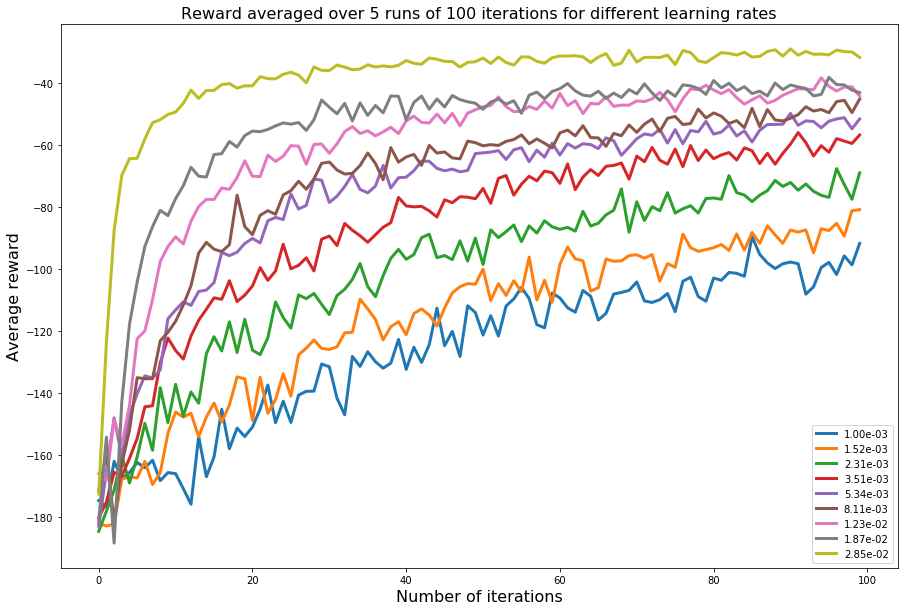

In [175]:
plt.figure(figsize=(15,10))
for i, lr in enumerate(learning_rates):
    if not (np.any(rewards[i] > 1000) or np.any(rewards[i] < -1000)): # triming inconsistent learning rates
        plt.plot(rewards[i], linewidth=3, label="%0.2e" % lr)
plt.xlabel('Number of iterations', size=16)
plt.ylabel('Average reward', size=16)
plt.title('Reward averaged over %d runs of %d iterations for different learning rates' % (n_runs, n_itr), size=16)
plt.legend()

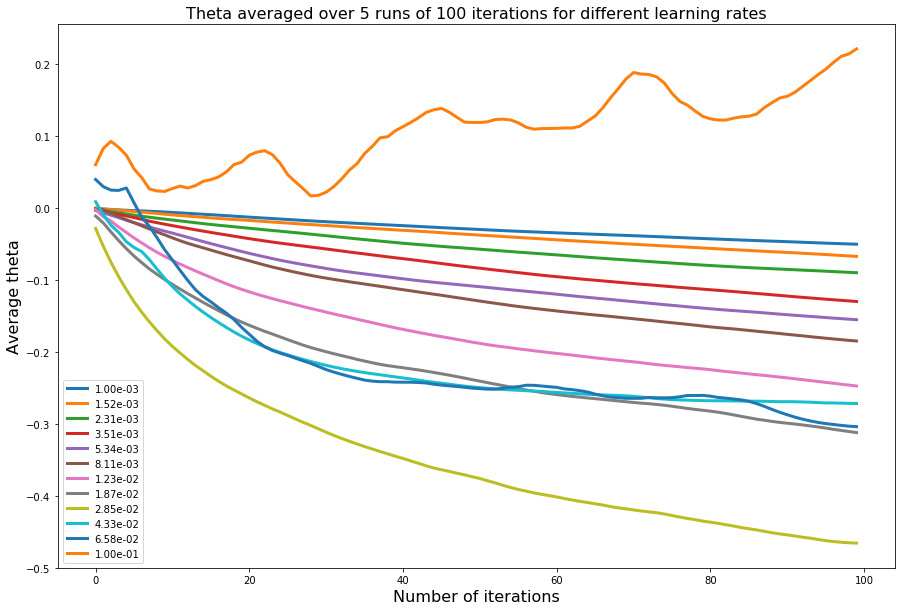

In [172]:
plt.figure(figsize=(15,10))
for i, lr in enumerate(learning_rates):
    if not (np.any(theta[i] > 2) or np.any(theta[i] < -2)): # triming inconsistent learning rates
        plt.plot(theta[i], linewidth=3, label="%0.2e" % lr)
plt.xlabel('Number of iterations', size=16)
plt.ylabel('Average theta', size=16)
plt.title('Theta averaged over %d runs of %d iterations for different learning rates' % (n_runs, n_itr), size=16)
plt.legend()

### Q2: Comparison for different values of $N$ using Adam stepper with $\alpha$ = 2.85e-2 (best previous value of the learning rate)

In [42]:
# parameters
T = 100 # Each trajectory will have at most T time steps
n_itr = 100 # Number of policy parameters updates
discount = 0.9 # Set the discount factor for the problem
learning_rate = 2.85e-2 # best previous learning rate
n_runs = 5 # number of runs (set to 5 according to the pdf)

Ns = np.logspace(0, 3, 10).astype(int) # logarithmically spaced value of N 

nb_curves = Ns.shape[0]

rewards = np.zeros((nb_curves, n_itr))
theta = np.zeros((nb_curves, n_itr))

for i, N in enumerate(Ns):
    for j in range(n_runs):
        stepper = AdamStep(0.9, 0.999, 1e-8, learning_rate)
        avg_return, mean_parameters = reinforce(n_itr, N, T, discount, stepper)
        
        rewards[i] += np.array(avg_return)
        theta[i] += np.array(mean_parameters)
        
rewards /= n_runs
theta /= n_runs

100%|██████████| 100/100 [06:40<00:00,  4.01s/it]


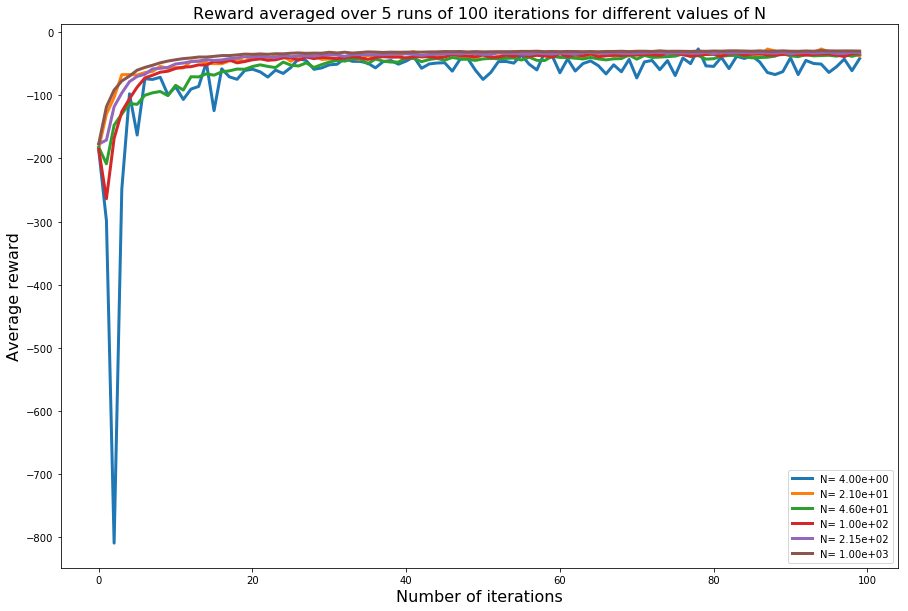

In [43]:
plt.figure(figsize=(15,10))
for i, N in enumerate(Ns):
    if not (np.any(rewards[i] > 1000) or np.any(rewards[i] < -1000)): # triming inconsistent learning rates
        plt.plot(rewards[i], linewidth=3, label="N= %0.2e" % N)
plt.xlabel('Number of iterations', size=16)
plt.ylabel('Average reward', size=16)
plt.title('Reward averaged over %d runs of %d iterations for different values of N' % (n_runs, n_itr), size=16)
plt.legend()

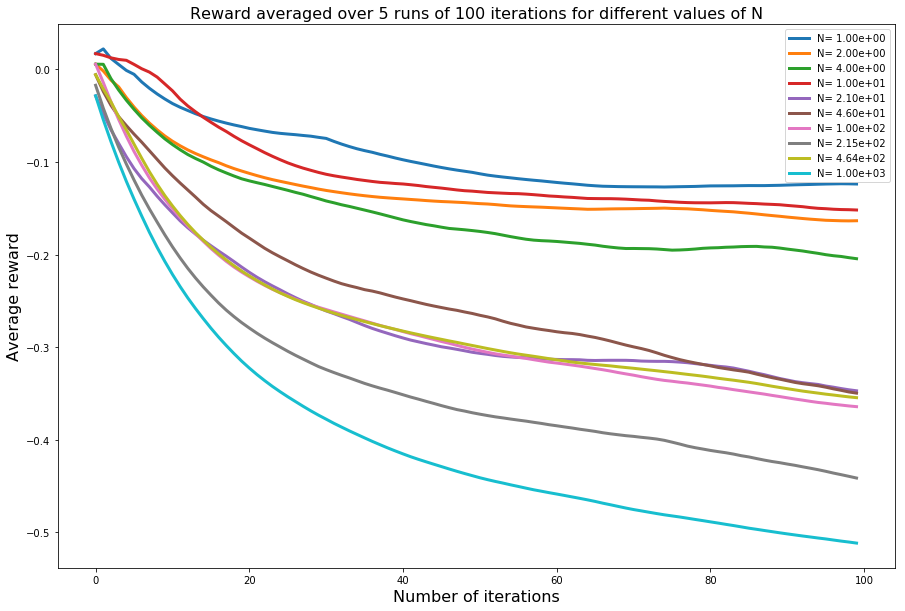

In [45]:
plt.figure(figsize=(15,10))
for i, N in enumerate(Ns):
    plt.plot(theta[i], linewidth=3, label="N= %0.2e" % N)
plt.xlabel('Number of iterations', size=16)
plt.ylabel('Average reward', size=16)
plt.title('Reward averaged over %d runs of %d iterations for different values of N' % (n_runs, n_itr), size=16)
plt.legend()

## 2. Off-Policy Reinforcement Learning with Value Function Approximation

Optimal K: [[-0.58840335]] Covariance S: 0.001


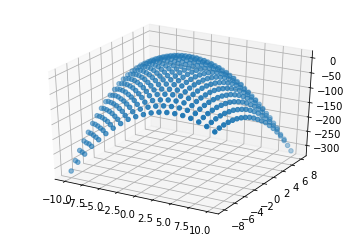

In [2]:
import lqg1d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from utils import collect_episodes, estimate_performance


env = lqg1d.LQG1D(initial_state_type='random')
discount = 0.9
horizon = 50

actions = discrete_actions = np.linspace(-8, 8, 20)


#################################################################
# Show the optimal Q-function
#################################################################
def make_grid(x, y):
    m = np.meshgrid(x, y, copy=False, indexing='ij')
    return np.vstack(m).reshape(2, -1).T

states = discrete_states = np.linspace(-10, 10, 20)
SA = make_grid(states, actions)
S, A = SA[:, 0], SA[:, 1]

K, cov = env.computeOptimalK(discount), 0.001
print('Optimal K: {} Covariance S: {}'.format(K, cov))

Q_fun_ = np.vectorize(lambda s, a: env.computeQFunction(s, a, K, cov, discount, 1))
Q_fun = lambda X: Q_fun_(X[:, 0], X[:, 1])

Q_opt = Q_fun(SA)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S, A, Q_opt)

plt.show()

### 2.1 behavioural policy

In [3]:
class BehaviorPolicy(object):
    def __init__(self, actions):
        self.actions = actions
        
    def draw_action(self, state):
        return np.random.choice(self.actions)

### 2.2 Fitted Q-iteration

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
beh_policy = BehaviorPolicy(discrete_actions)

In [6]:
dataset = collect_episodes(env, n_episodes=100,
                           policy=beh_policy, horizon=horizon)

In [7]:
keys = ['actions', 'states', 'rewards', 'next_states']
data = dict([(k, []) for k in keys])
for i in range(len(dataset)):
    data['actions'].extend(dataset[i]['actions'])
    data['states'].extend(dataset[i]['states'])
    data['rewards'].extend(dataset[i]['rewards'])
    data['next_states'].extend(dataset[i]['next_states'])
    
data['actions'] = np.array(data['actions'])
data['states'] = np.array(data['states']).squeeze()
data['rewards'] = np.array(data['rewards'])
data['next_states'] = np.array(data['next_states']).squeeze()

In [8]:
class fqiPolicy(object):
    def __init__(self, actions, theta):
        self.actions = actions
        self.theta = theta
        
    def draw_action(self, s):
        phi = np.array([self.actions, s*self.actions, s**2 + self.actions**2]).T.dot(self.theta)
        return self.actions[np.argmax(phi)]

In [9]:
def getApproxFunction(states, actions, theta):
    A, S = np.meshgrid(actions, states)
    Z = np.dstack((
            A,
            A * S,
            S ** 2 + A ** 2
    ))
    
    return np.sum(Z * theta[None, None, :], axis=-1)

In [10]:
def fqi(data, actions, gamma, lambd, epsilon=1e-12, max_iter=1000):
    J = []
    n = len(data[list(data.keys())[0]])
    d = 3 # hard-coded
    
    y = np.zeros((n))
    theta = np.zeros((d,))
    
    for k in range(max_iter):
        
        for i in range(n):
            s_i = data['next_states'][i]
            r_i = data['rewards'][i]
            
            y[i] = r_i + gamma * np.max(np.array([actions, s_i*actions, s_i**2 + actions**2]).T.dot(theta))
        
        Z = np.vstack((data['actions'],
                      data['states'] * data['actions'],
                      data['states']**2 + data['actions']**2)).T
    
        theta_prev = theta.copy()
        theta = np.linalg.solve(Z.T.dot(Z) + lambd * np.identity(3), Z.T.dot(y))
        
        pol = fqiPolicy(actions, theta)
        J.append(estimate_performance(env, policy=pol, horizon=50, n_episodes=50, gamma=gamma))
        
        if np.linalg.norm(theta_prev - theta) < epsilon:
            break

    return J, theta

In [11]:
J_hist, theta = fqi(data, actions, 0.9, 2)

In [12]:
Q = getApproxFunction(states, actions, theta)

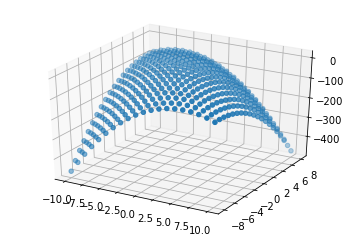

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S.flatten(), A.flatten(), Q.flatten())
plt.show()

final value:  -31.1400021484


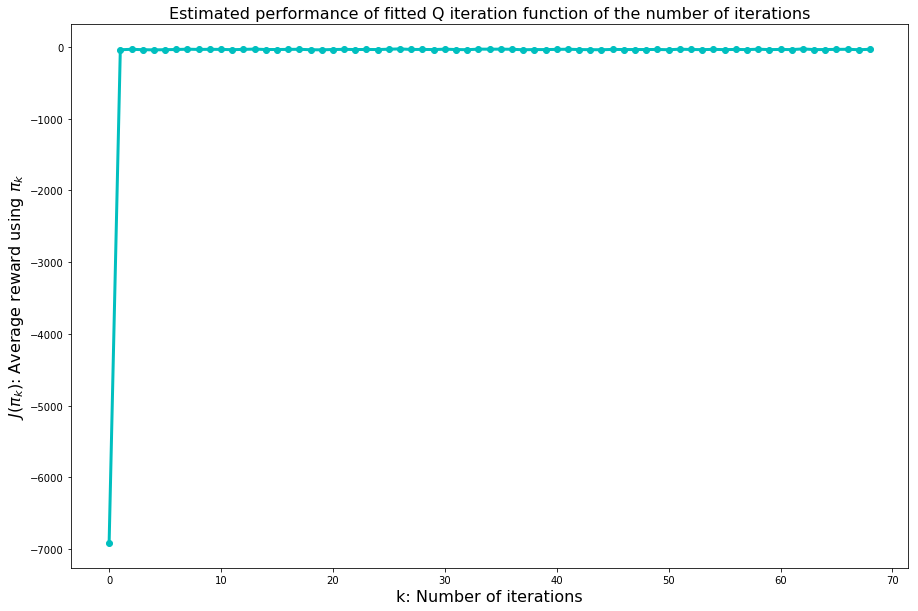

In [23]:
plt.figure(figsize=(15,10))
plt.xlabel('k: Number of iterations', size=16)
plt.ylabel(r'$J(\pi_k)$: Average reward using $\pi_{k}$', size=16)
plt.title("Estimated performance of fitted Q iteration function of the number of iterations", size=16)
plt.plot(J_hist, 'co-', linewidth=3)
print("final value: ", J_hist[-1])

### tuning the $\lambda$ parameter for $\gamma = 0.9$

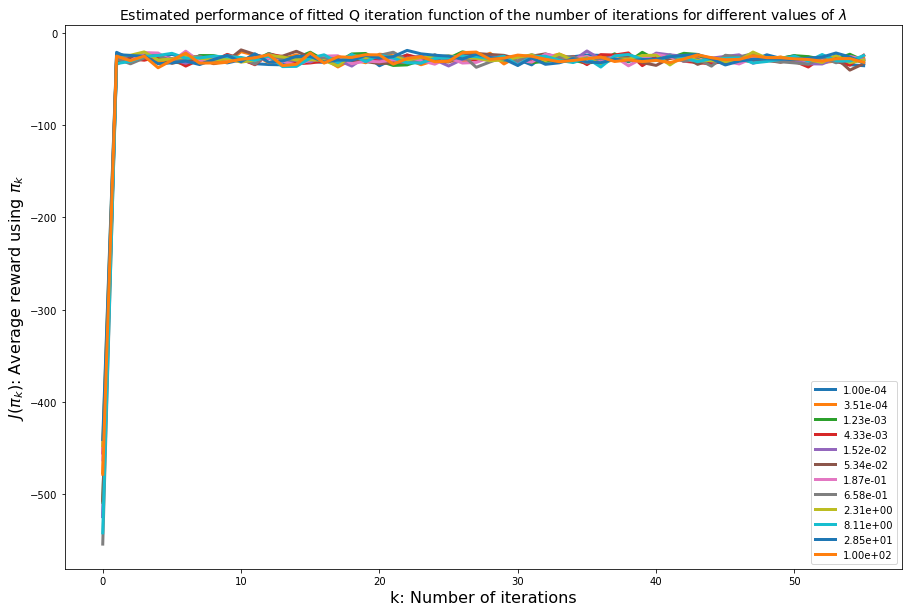

In [17]:
lambdas = np.logspace(-4, 2, 12)

plt.figure(figsize=(15,10))
for l in lambdas:
    J_hist, _ = fqi(data, actions, 0.9, l)
    plt.plot(J_hist, linewidth=3, label="%0.2e" % l)
plt.xlabel('k: Number of iterations', size=16)
plt.ylabel(r'$J(\pi_k)$: Average reward using $\pi_{k}$', size=16)
plt.title(r'Estimated performance of fitted Q iteration function of the number of iterations for different values of $\lambda$', size=14)
plt.legend()

### tuning the $\gamma$ parameter for $\lambda = 2$

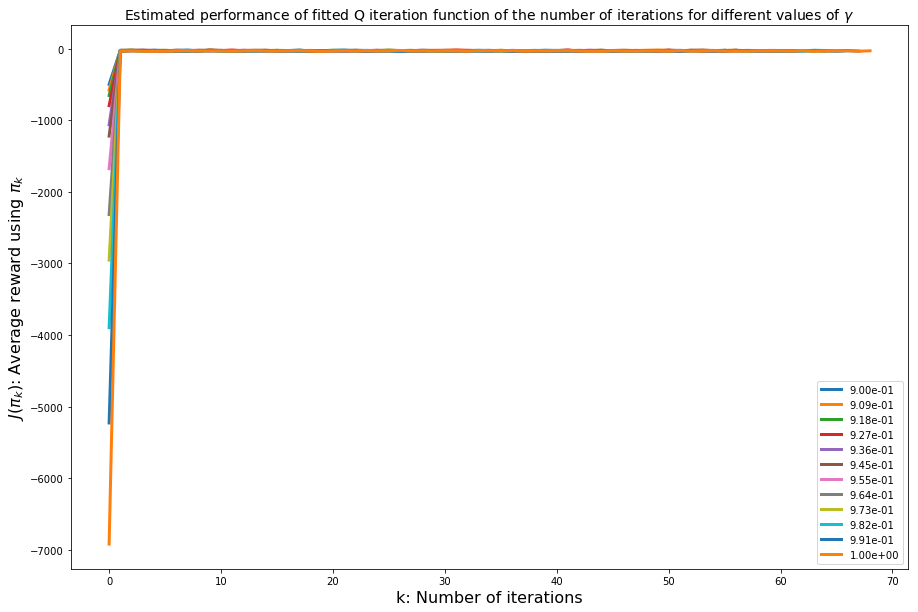

In [20]:
gammas = np.linspace(0.9, 1, 12)
best_lambda = 2 # it isn't the best lambda but there isn't much difference between the value of lambda (see previous graph)

plt.figure(figsize=(15,10))
for g in gammas:
    J_hist, _ = fqi(data, actions, g, best_lambda)
    plt.plot(J_hist, linewidth=3, label="%0.2e" % g)
plt.xlabel('k: Number of iterations', size=16)
plt.ylabel(r'$J(\pi_k)$: Average reward using $\pi_{k}$', size=16)
plt.title(r'Estimated performance of fitted Q iteration function of the number of iterations for different values of $\gamma$', size=14)
plt.legend()